# DBScan Feature Extraction for PEX Pipe

In [72]:
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
from sklearn.cluster import DBSCAN
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import os

## Functions

In [73]:
def IR_PCA(input_data, PCs):
    
    pca_model = PCA(n_components = PCs)
    data_PCs = pca_model.fit_transform(input_data)
    
    columns_list = ['PC'+ str(x) for x in range(1, PCs+1)]
    PC_df = pd.DataFrame(data = data_PCs, columns = columns_list)
    
    feature_weights = pca_model.components_
    loadings_df = pd.DataFrame(feature_weights)
    
    print('Explained variation per principal component: {}'.format(pca_model.explained_variance_ratio_))
    
    return(PC_df, loadings_df, pca_model)

def IR_DBSCAN(input_data, eps, min_samples):
    # Apply DBSCAN
    db = DBSCAN(eps, min_samples).fit(input_data)

    labels = db.labels_
    # Get number of cores and features, cores should be two for the PEX samples 
    numberOfCores, numberOfFeautures = db.components_

    return(db, labels, numberOfFeautures, numberOfCores)

def distribution_Selection(df, distributionIdx, numberOfSigmas):
    """
    df - the pandas datframe that you want to 
    """
    
    df[distributionIdx] = df[distributionIdx].astype(float)

    #creating variable for the array of Polyethylene Area
    area = df['1981.7 - 2095.8'].values

    # Use Gaussian KDE to find the center position of the rightmost mode by creating x coords
    # and then using np.argmax to determine the point with the highest number of counts
    kde = gaussian_kde(area)
    xs = np.linspace(area.min(), area.max(), 1000) 
    modePosition = xs[np.argmax(kde(xs))]

    # Use only the values greater than 1.5 to determine the std of the PE peaks
    positive_vals = area[area > 1.5]
    sigma = positive_vals.std()

    lowerDistributionBound = modePosition - numberOfSigmas * sigma
    upperDistributionBound = modePosition + numberOfSigmas * sigma

    # Select the range of PE normalization integral to be accepted by the mask
    mask_selected = (area >= lowerDistributionBound) & (area <= upperDistributionBound)
    selected_indexes = df.index[mask_selected]
    discarded_indexes = df.index[~mask_selected]

    return selected_indexes, discarded_indexes, mask_selected, modePosition, area


## Manage the Dataset

        map_x    map_y Sample Name  1981.7 - 2095.8  1799.3865662863864  \
0     37985.1  23998.5    0d 820um          3.41326                   0   
1     37990.5  23998.5    0d 820um          3.49233                   0   
2     37996.0  23998.5    0d 820um          3.45759                   0   
3     38001.4  23998.5    0d 820um          3.42111                   0   
4     38006.8  23998.5    0d 820um          3.34035                   0   
...       ...      ...         ...              ...                 ...   
6139  38180.5  24040.4    7d 830um          4.23929                   0   
6140  38185.9  24040.4    7d 830um          4.07937                   0   
6141  38191.3  24040.4    7d 830um          4.12860                   0   
6142  38196.8  24040.4    7d 830um          4.08492                   0   
6143  38202.2  24040.4    7d 830um          4.04909                   0   

      1797.8025992385988  1796.2186321908116  1794.6346651430244  \
0               0.000501       

(-1.0, 5.455852222222222)

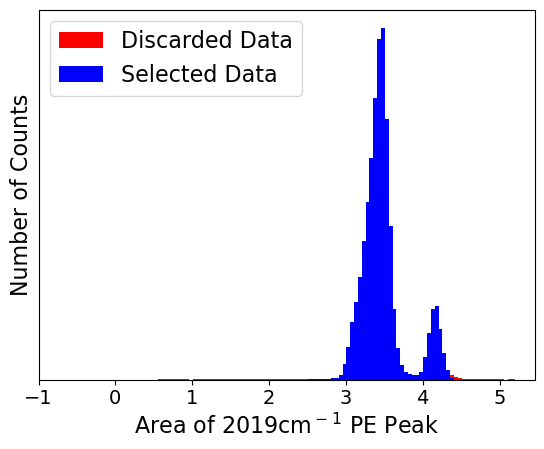

In [76]:
path ='../data/'
filename = path + 'SMP65#010 100d 820um'
filename += '.csv'

df = pd.read_csv(filename)
# Obtain the last Index before starting wavenumbers, this may change depending on data
last_nonwavenum_idx = df.columns.get_loc('1981.7 - 2095.8') + 1
# Create an array of strings containing the wavenumbers
wavenumbers = df.columns[last_nonwavenum_idx:].astype(str)

allFiles = os.listdir(path)

trainingFiles = [file for file in allFiles if 'SMP65#010' in file and file.endswith('.csv')]

trainingDataframe = [pd.read_csv(path+file) for file in trainingFiles]

trainingDataframe = pd.concat(trainingDataframe)

print(trainingDataframe)


selected_indexes, discarded_indexes, mask_selected, modePosition, areaPE = distribution_Selection(trainingDataframe, '1981.7 - 2095.8', 3)

bin_width = 0.05
bins = np.arange(min(areaPE), max(areaPE) + bin_width, bin_width)

plt.hist(areaPE,bins=bins, color='r')
plt.hist(areaPE[mask_selected], bins=bins, color='b')
plt.yticks([])
plt.xticks(fontsize=14)
plt.ylabel('Number of Counts', fontsize=16)
plt.xlabel(f'Area of 2019cm$^-$$^1$ PE Peak', fontsize=16)
plt.legend(['Discarded Data', 'Selected Data'], fontsize=16, loc='upper left')
plt.xlim([-1, modePosition + 2])

# Perform the PCA Analysis

Explained variation per principal component: [0.43808749 0.2937763 ]
Raw Dataset shape:  (52224, 505) Filtered Dataset shape:  (51771, 505)


c:\Users\Zach\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


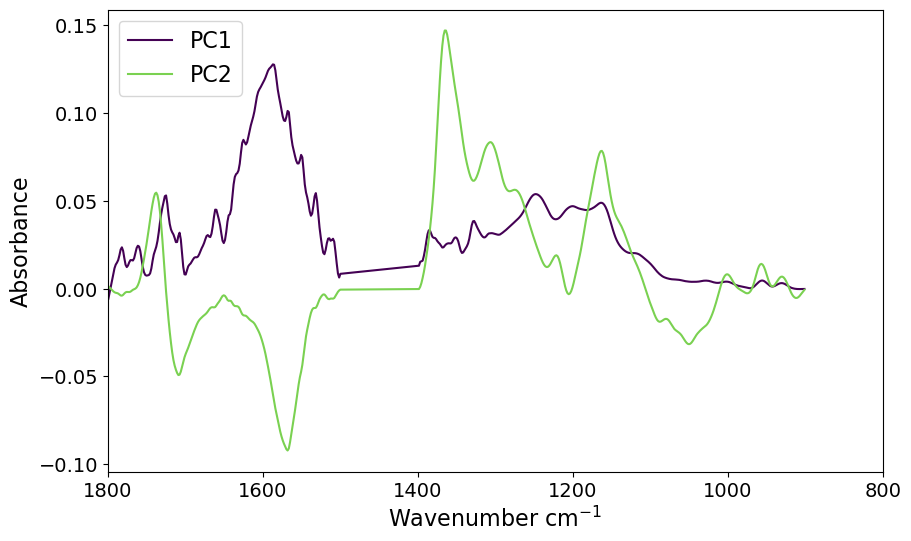

In [ ]:
PCs = 2
# Create dataset containing ONLY the wavenumbers
rawData = trainingDataframe[wavenumbers].copy()
# Modify created dataset to contain ONLY the masked values
Masked_PC_inputData = rawData[mask_selected].values
# Train a PCA model on these values
PCA_df_init, loadings_df_init, pca_model = IR_PCA(rawData   , PCs=PCs)

print("Raw Dataset shape: ", rawData.shape, "Filtered Dataset shape: ", Masked_PC_inputData.shape)

# Save the model to a pickle file
with open('pca_model.pkl', 'wb') as f:
    pickle.dump(pca_model, f)
# Open the same model
with open('pca_model.pkl', 'rb') as f:
    loaded_pca_model = pickle.load(f)

# Use the model again to get the same result
data_PCs = loaded_pca_model.transform(rawData.values)
columns_list = ['PC'+ str(x) for x in range(1, PCs+1)]
PCA_df = pd.DataFrame(data = data_PCs, columns = columns_list)

PCA_df['map_x'] = df['map_x'].copy()
PCA_df['map_y'] = df['map_y'].copy()
#PCA_df['Sample Name'] = df['Sample Name']

cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 0.8, PCs))

plt.figure(figsize=(10,6))
plt.xlabel('Wavenumber cm$^{-1}$', fontsize=16)
plt.ylabel('Absorbance', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
for i in range(PCs):
    loadings = savgol_filter(loadings_df_init.iloc[i, :].values, 9, 1)
    plt.plot(
        wavenumbers.astype(float),
        loadings,
        color=colors[i],
        label=f"PC{i+1}"
    )
plt.legend(['PC1', 'PC2'], fontsize=16, loc='upper left')
#plt.xlim(wavenumbers[0], wavenumbers[-1])
plt.xlim(1800, 900)
plt.savefig("PC1_loading_spectrum.jpeg", dpi=900)

# Plotting the PCA Analysis

Preparing data for plottings

In [88]:
PC1 = PCA_df['PC1'].to_numpy()
PC2 = PCA_df['PC2'].to_numpy()

#Reposition the mapping to start at 0,0 
Map_x = df['map_x'].to_numpy()
Map_y = df['map_y'].to_numpy()
Map_y2 = []
Map_x2 = []
Min_x = min(Map_x)
Min_y = min(Map_y)

Map_x2 = Map_x - Min_x
Map_y2 = Map_y - Min_y

x_adjusted=(np.unique(Map_x2)).tolist()
y_adjusted=(np.unique(Map_y2)).tolist()

X,Y = np.meshgrid(x_adjusted, y_adjusted)

Xsize, Ysize = len(x_adjusted), len(y_adjusted)
print("Length of X, Y: ", Xsize, Ysize, "\n")

print("Length of X*Y: ",len(x_adjusted)*len(y_adjusted), "\n")


print("Lenght of PC1: ", len(PC1), "Legnth of PC2: ", len(PC2), "\n")
# Format PC1 for plotting
PC1 = np.reshape(PC1.copy(), (Ysize, Xsize))

# Format PC2 for plotting
PC2 = np.reshape(PC2.copy(), (Ysize,Xsize))

# Setting up the mask for plotting
PC1_masked =  np.ma.array(PC1, mask=~mask_selected)
PC2_masked =  np.ma.array(PC2, mask=~mask_selected)


Length of X, Y:  64 96 

Length of X*Y:  6144 

Lenght of PC1:  52224 Legnth of PC2:  52224 



ValueError: cannot reshape array of size 52224 into shape (96,64)

Creating Figures and Plotting the PCs

[]

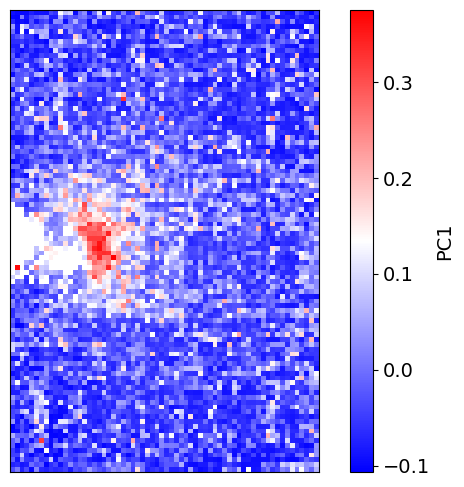

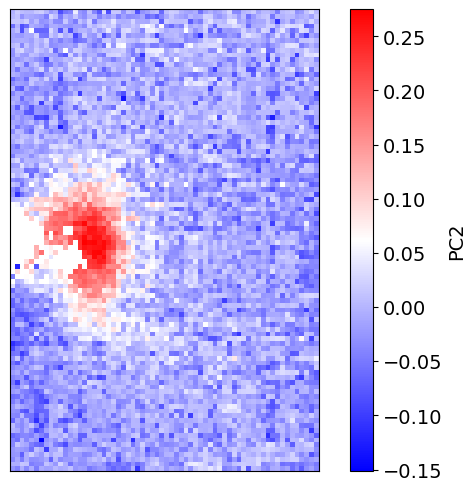

In [ ]:
# Prepare colormap
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 0.8, len(loadings_df_init)))
cmap.set_bad(color='0.7')  # dull grey for masked values

"""
Plotting the first Principal Component
"""

fig1, ax1 = plt.subplots(figsize=(8, 6))

im1 = ax1.pcolormesh(X, Y, PC1_masked, cmap='bwr', shading='auto')

cbar = fig1.colorbar(im1, ax=ax1)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'PC1', fontsize=14)

ax1.set_aspect('equal')

ax1.set_xticks([])
ax1.set_yticks([])

"""
Plotting the second Principal Component 
"""

fig2, ax2 = plt.subplots(figsize=(8, 6))

im2 = ax2.pcolormesh(X, Y, PC2_masked, cmap='bwr', shading='auto')

cbar = fig2.colorbar(im2, ax=ax2)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'PC2', fontsize=14)

ax2.set_aspect('equal')

ax2.set_xticks([])
ax2.set_yticks([])


## Density Based Scan for Different 